In [2]:
import torch
import numpy as np
import time
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pathlib
from torchvision import datasets, models, transforms
import torch.optim as optim
import os

In [4]:
data_dir = 'data'
train_data = 'seg_train/seg_train'
test_data = 'seg_test/seg_test'

In [5]:
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    train_data: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, std)
    ]),
    test_data: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, std)
    ]),
}

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [train_data, test_data]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in [train_data, test_data]}

dataset_sizes = {x: len(image_datasets[x]) for  x in [train_data,test_data]}

class_names = image_datasets[train_data].classes

print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in [train_data, test_data]:
            if phase == train_data:
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == train_data):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == train_data:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == train_data:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == test_data and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/home/pooria/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pooria/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------
seg_train/seg_train Loss: 0.9087 Acc: 0.6871
seg_test/seg_test Loss: 0.3486 Acc: 0.8887

Epoch 2/5
----------
seg_train/seg_train Loss: 0.7054 Acc: 0.7595
seg_test/seg_test Loss: 0.3224 Acc: 0.9023

Epoch 3/5
----------
seg_train/seg_train Loss: 0.6131 Acc: 0.7920
seg_test/seg_test Loss: 0.3578 Acc: 0.8900

Epoch 4/5
----------
seg_train/seg_train Loss: 0.5442 Acc: 0.8145
seg_test/seg_test Loss: 0.3077 Acc: 0.8980

Epoch 5/5
----------
seg_train/seg_train Loss: 0.5206 Acc: 0.8184
seg_test/seg_test Loss: 0.2964 Acc: 0.9033

Training complete in 103m 22s
Best test Acc: 0.903333


In [21]:
x = [1, 2, 3, 4, 5]
y_train = [0.6871, 0.7595, 0.7920, 0.8145, 0.8184]
y_test = [0.8887, 0.9023, 0.8900, 0.8980, 0.9033]

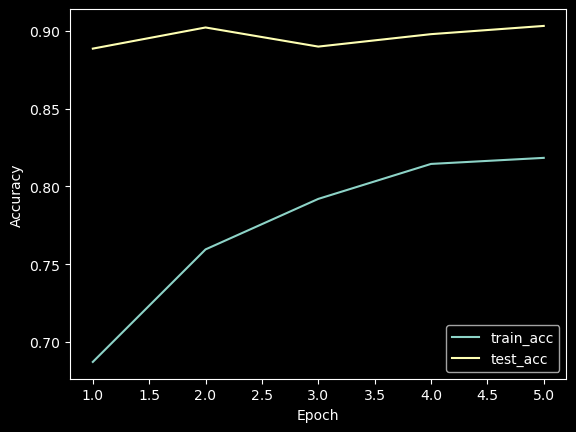

In [28]:
plt.style.use('dark_background')
plt.plot(x, y_train, label='train_acc')
plt.plot(x, y_test, label='test_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')